# Accident risk assessment

**The main objective of the project** is to create a system that could assess the risk of an accident along a selected traffic route. Risk is defined as the probability of an accident with any damage to the vehicle. Once the driver has booked the vehicle, got behind the wheel and selected the route, the system should assess the risk level. If the risk level is high, the driver will see a warning and route recommendations.

**Task Solution Idea from the customer**: 
1. Create an accident prediction model (target value - at_fault (culprit) in the parties table)
    - For the model, select the type of culprit - car only.
    - Select cases where the accident resulted in any damage to the vehicle other than SCRATCH (scratch).
    - For modeling, limit the data for 2012 - they are the most recent.
    - It is obligatory to take into account the factor of the age of the car.
2. On the basis of the model to investigate the main factors of road accidents.
3. To understand whether the results of modeling and analysis of the importance of factors will help to answer the questions:
    - Is it possible to create an adequate system for assessing driver risk when issuing a car?
    - What other factors need to be considered?
    - Does the car need to be equipped with any sensors or camera?

## Data loading

In [1]:
# imports
from sqlalchemy import create_engine

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')


# import dictionary containing db connection info
from configs import db_config

In [2]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'], # username
    db_config['pwd'],  # password
    db_config['host'], # host
    db_config['port'], # port
    db_config['db'],   # database name
)

In [3]:
# creating a connection
engine = create_engine(connection_string) 

## Primary table examination

Before starting work, let's check:

- Whether the number of tables corresponds to the problem condition
- Whether all tables have a data set
- Is there a common key to link the tables

In [4]:
query = """
SELECT table_name
FROM 
    information_schema.tables
WHERE 
    table_schema = 'public';
"""

tables = pd.read_sql_query(query, con=engine)
tables

,table_name
0,case_ids
1,collisions
2,parties
3,vehicles


The number of tables in the diagram and their names correspond to those presented in the diagram.

In [5]:
rows = pd.DataFrame(columns=['table_name', 'row_count'])

def row_count(table):
    query = f"""
    SELECT COUNT(*)
    FROM public.{table}
    """
    return pd.read_sql_query(query, con=engine).values[0][0]
    
for table in tables['table_name'].to_list():
    rows.loc[len(rows.index)] = [table, row_count(table)]
    
display(rows)

,table_name,row_count
0,case_ids,1400000
1,collisions,1400000
2,parties,2752408
3,vehicles,1021234


All tables have data (more than 1 million rows).

In [6]:
def exist_case_id(table):
    query = f"""
    SELECT 
        column_name
    FROM 
        information_schema.columns
    WHERE 
        table_schema = 'public'
        AND table_name = '{table}'
        AND column_name = 'case_id';
    """
    
    if pd.read_sql_query(query, con=engine).shape[0] > 0:
        return f'{table}: Ключ (case_id) есть'
    return 'Общий ключ не найден'

for table in tables['table_name'].to_list():
    print(exist_case_id(table))

case_ids: Ключ (case_id) есть
collisions: Ключ (case_id) есть
parties: Ключ (case_id) есть
vehicles: Ключ (case_id) есть


According to the presented ER-diagram, the common key is `case_id`. The column with this name is present in each of the tables.

Thus, the **primary table examination was successful**: all tables contain data, the number of tables and their names are as expected, and the common key is contained in each of them.

## Statistical analysis of road traffic accident factors

Let's take a look at which months have the most accidents:

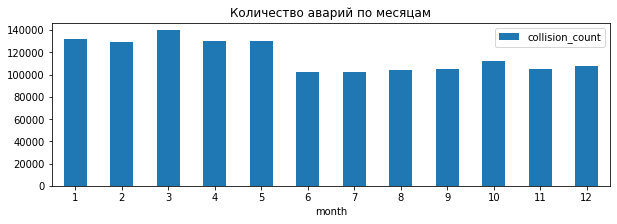

,collision_count
month,
1,132044
2,128858
3,139581
4,130180
5,130316
6,102594
7,102227
8,104089
9,105159


In [7]:
query = '''
SELECT 
    EXTRACT(MONTH FROM collision_date)::integer AS month,
    COUNT(*) AS collision_count
FROM 
    collisions
GROUP BY 
    month
ORDER BY 
    month ASC;
'''

collisions_by_month = pd.read_sql_query(query, con=engine).set_index('month')

# построение графика
collisions_by_month.plot(kind='bar', title='Количество аварий по месяцам', figsize=(10, 3))
plt.xticks(rotation=0)
plt.show()

# данные
display(collisions_by_month.style.background_gradient('Greens'))

As we can see, the highest number of accidents is registered at the beginning of the year - in the winter and spring months. Just at this time in some regions, weather conditions change, snow appears/sleet and many people switch to summer tires early, which leads to a difficult situation on the roads. Fewer accidents occur during the summer months. In the fall, there is a slight increase.

To better understand the data, let's answer a couple more questions.

**Question #1** \
"Does the age of the car affect the amount of insurance payout in the event of serious damage?"

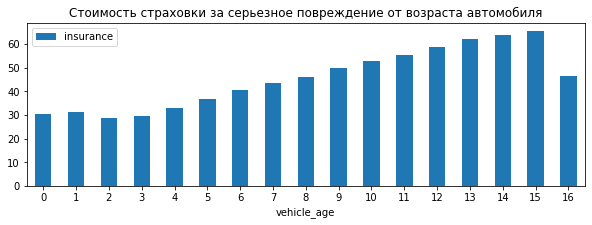

,insurance,case_count
vehicle_age,,
0,30.283896,1929
1,31.285428,2636
2,28.587217,7387
3,29.588541,14586
4,32.814542,11066
5,36.828289,9091
6,40.605540,7603
7,43.479229,7867
8,46.129659,7375


In [8]:
query = """
SELECT v.vehicle_age,
    AVG(p.insurance_premium) AS insurance, 
    COUNT(c.case_id) AS case_count
FROM collisions AS c
JOIN parties AS p ON c.case_id = p.case_id
JOIN vehicles AS v ON v.case_id = p.case_id
WHERE c.collision_damage = 'severe damage'
    AND v.vehicle_age IS NOT NULL
GROUP BY v.vehicle_age
ORDER BY v.vehicle_age
"""

df_pivot = pd.read_sql_query(query, con=engine).set_index('vehicle_age')

# plot
df_pivot.plot(kind='bar', y='insurance', title='Стоимость страховки за серьезное повреждение от возраста автомобиля', figsize=(10, 3))
plt.xticks(rotation=0)
plt.show()

# data
df_pivot.style.background_gradient('Greens')

The general trend: the older the car, the higher the average insurance payout for serious damage. A sharp decline is observed for cars aged 16 years, which is due to the extremely low number of registered cases.

**Question #6** \.
"Which body type of car was most often involved in an accident not caused by the driver with above-average damage severity?"


In [9]:
query = """
WITH serious_damage AS (
    SELECT v.vehicle_type, 
        COUNT(c.case_id) AS case_count
    FROM collisions AS c
    JOIN vehicles AS v ON v.case_id = c.case_id
    WHERE c.collision_damage IN ('severe damage', 'fatal tc')
        AND c.primary_collision_factor = 'other than driver'
    GROUP BY v.vehicle_type
),
all_cases AS (
    SELECT v.vehicle_type,
        COUNT(c.case_id) AS case_count
    FROM collisions AS c
    JOIN vehicles AS v ON v.case_id = c.case_id
    WHERE c.collision_damage IS NOT NULL
        AND c.primary_collision_factor = 'other than driver'
    GROUP BY v.vehicle_type
)
    
SELECT a.vehicle_type,
    a.case_count AS all_cases_count,
    s.case_count AS serious_cases_count,
    (s.case_count::numeric / a.case_count::numeric * 100) AS percent
FROM all_cases AS a
JOIN serious_damage AS s ON s.vehicle_type = a.vehicle_type
ORDER BY a.case_count DESC;
"""

df = pd.read_sql_query(query, con=engine)

# data
df.style.background_gradient('Greens')

,vehicle_type,all_cases_count,serious_cases_count,percent
0,sedan,8868,187,2.108705
1,coupe,5935,459,7.733783
2,minivan,782,122,15.601023
3,hatchback,523,87,16.634799
4,other,51,7,13.725490


The highest number of cases of damage through no fault of the driver is registered for cars with the body type "sedan", however, the maximum number of cases of serious/fatal damage is observed for "coupe". The hatchback wins in percentage terms - 16% of all reported cases of no fault of the driver were accompanied by major damage.

## Data preparation

Prepare a dataset for future use. 

**Requirements:**

1. The target value is the at_fault in the parties table
2. For the model, select the culprit type - car only
3. Select cases where the accident resulted in any damage to the vehicle other than SCRATCH (scratch).
4. For modeling, limit the data for 2012 - they are the most recent.
5. It is mandatory to take into account the age factor of the vehicle

Since some columns in different tables have the same names, let's list the names of all columns and rename them if necessary. Let us immediately select the attributes that may influence the risk of a road accident.

In [10]:
columns = [
#     'c.case_id',                      # incident id - not needed for the model
#     'c.county_city_location',         # neighborhood number - we'll just take the name
    'c.county_location',              # district name is a categorical attribute, take
    'c.distance',                     # distance from the main road may affect
    'c.direction',                    # the direction of travel, can affect
#     'c.intersection',                 # intersection, partially duplicated in c.location_type
    'c.weather_1',                    # the weather can affect
    'c.location_type',                # the type of road may affect
#     'c.collision_damage',             # the severity of the accident, unknown prior to the accident
    'c.party_count',                  # the number of participants is still unclear, so we'll leave it at that
#     'c.primary_collision_factor',     # major factor in the accident, unknown before the accident
#     'c.pcf_violation_category',       # category of violation, unknown before the accident
#     'c.type_of_collision',            # type of accident, unknown before the accident
    'c.motor_vehicle_involved_with',  # additional parties to the accident, could affect
    'c.road_surface',                 # the condition of the road may affect
    'c.road_condition_1',             # road conditions, can affect
    'c.lighting',                     # illumination, can affect
    'c.control_device',               # control device - not clear yet, let's leave it at that.
    'c.collision_date',               # can be converted to day of the week and month
    'c.collision_time',               # can be converted to hours or part of a day
#     'v.id',                           # id of table vehicle
#     'v.case_id',                      # accident id repeat
#     'v.party_number',                 # no data in the description
    'v.vehicle_type',                 # body type may affect
    'v.vehicle_transmission',         # gearbox type, may affect
    'v.vehicle_age',                  # age of the vehicle, customer requirement
#     'p.id',                           # id of table parties
#     'p.case_id',                      # accident id repeat
#     'p.party_number',                 # participant number, identifier
#     'p.party_type',                   # participant type, by condition only car, not needed
    'p.at_fault',                     # perpetrator (0/1) - target attribute
#     'p.insurance_premium',            # amount of insurance, unknown before the accident
    'p.party_sobriety',               # a participant's sobriety, can affect
    'p.party_drug_physical',          # the participant's condition may affect
#     'p.cellphone_in_use'              # having a cell phone has no effect
]

In [11]:
query = f"""
SELECT {', '.join(columns)}    
FROM collisions AS c
FULL JOIN parties AS p ON c.case_id = p.case_id
FULL JOIN vehicles AS v ON (c.case_id = v.case_id AND p.party_number = v.party_number)
WHERE EXTRACT('year' FROM c.collision_date) = 2012
    AND p.party_type = 'car'
    AND c.collision_damage NOT IN ('scratch')
    AND v.vehicle_age IS NOT NULL
"""

df = pd.read_sql_query(query, con=engine)
display(df.head())
df.info()

,county_location,distance,direction,weather_1,location_type,party_count,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time,vehicle_type,vehicle_transmission,vehicle_age,at_fault,party_sobriety,party_drug_physical
0,los angeles,20.0,south,clear,None,2,other motor vehicle,dry,normal,daylight,functioning,2012-04-15,17:05:00,sedan,auto,2,0,had not been drinking,None
1,contra costa,21.0,east,clear,None,2,other motor vehicle,dry,normal,dark with street lights,functioning,2012-01-15,02:00:00,sedan,manual,10,0,had not been drinking,None
2,san joaquin,378.0,south,cloudy,None,2,other motor vehicle,dry,normal,daylight,none,2012-04-13,18:32:00,sedan,auto,2,0,had not been drinking,None
3,san bernardino,150.0,west,clear,None,2,other motor vehicle,dry,None,daylight,none,2012-04-29,17:10:00,sedan,auto,3,0,had not been drinking,None
4,los angeles,450.0,east,clear,highway,2,other motor vehicle,dry,normal,daylight,none,2012-04-18,17:15:00,sedan,auto,10,0,had not been drinking,None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54554 entries, 0 to 54553
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   county_location              54554 non-null  object 
 1   distance                     54554 non-null  float64
 2   direction                    42097 non-null  object 
 3   weather_1                    54389 non-null  object 
 4   location_type                25511 non-null  object 
 5   party_count                  54554 non-null  int64  
 6   motor_vehicle_involved_with  54407 non-null  object 
 7   road_surface                 54225 non-null  object 
 8   road_condition_1             54317 non-null  object 
 9   lighting                     54402 non-null  object 
 10  control_device               54348 non-null  object 
 11  collision_date               54554 non-null  object 
 12  collision_time               54470 non-null  object 
 13  vehicle_type    

We left a total of 18 attributes + the target variable `at_fault`. Let's look at the number of omissions in the columns as a percentage:

In [12]:
pd.DataFrame(df.isna().mean()*100).style.background_gradient('Greens')

,0
county_location,0.000000
distance,0.000000
direction,22.834256
weather_1,0.302453
location_type,53.237160
party_count,0.000000
motor_vehicle_involved_with,0.269458
road_surface,0.603072
road_condition_1,0.434432
lighting,0.278623


In the collected dataset there are three columns with a large number of skips (more than 20%). It is unlikely to restore these data correctly, and we do not want to delete such a large number of rows with gaps, so let's delete the `location_type`, `direction` and `party_drug_physical` attributes.

In [13]:
df.drop(columns=['direction', 'location_type', 'party_drug_physical'], inplace=True)

Let's look at the rest of the attributes individually.

***County_location***

In [14]:
df['county_location'].value_counts()

los angeles        15715
orange              5079
san diego           3675
san bernardino      3592
riverside           3205
sacramento          2116
alameda             1838
santa clara         1779
ventura             1441
kern                1389
fresno              1057
contra costa         956
san mateo            915
san joaquin          892
stanislaus           786
santa barbara        704
tulare               700
sonoma               677
placer               557
monterey             550
solano               540
san francisco        483
san luis obispo      428
santa cruz           422
merced               383
marin                361
madera               320
humboldt             319
butte                312
el dorado            286
shasta               275
yolo                 266
kings                244
napa                 208
imperial             205
mendocino            189
nevada               181
tehama               145
sutter               143
tuolumne             122


A categorical attribute with the name of the region. All values are already lower-cased, there are no implicit duplicates or omissions, however, there are quite a lot of unique values in the sum. Since it would be inexpedient to combine them into one group, we will leave them as they are.

***Distance***

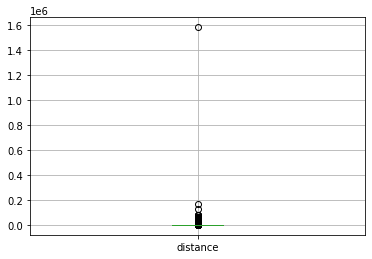

count    5.455400e+04
mean     8.761480e+02
std      7.348699e+03
min      0.000000e+00
25%      9.000000e+00
50%      1.430000e+02
75%      5.757500e+02
max      1.584000e+06
Name: distance, dtype: float64

In [15]:
df.boxplot('distance')
plt.show()

df['distance'].describe()

In [16]:
df['distance'].quantile(0.99)

11616.0

99% of all data are distributed up to the value 11616. Let's limit the range of possible values from above to this value.

In [17]:
df = df.loc[df['distance'] <= 11616]

***Weather_1***

In [18]:
df['weather_1'].value_counts(dropna=False)

clear      43327
cloudy      8087
raining     2097
fog          168
NaN          165
snowing      144
other         29
wind          11
Name: weather_1, dtype: int64

Categorical attribute. There are a small number of gaps, let's fill them with the already existing "other" cap. We will also rename the column for convenience.

In [19]:
df['weather_1'] = df['weather_1'].fillna('other')
df.rename(columns={'weather_1': 'weather'}, inplace=True)

***Party_count***

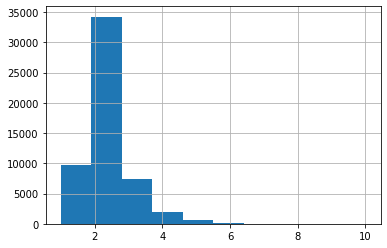

In [20]:
df['party_count'].hist()
plt.show()

All values are within normal limits, no omissions.

***Motor_vehicle_involved_with***

In [21]:
df['motor_vehicle_involved_with'].value_counts(dropna=False)

other motor vehicle               39725
fixed object                       7947
non-collision                      2129
other object                       1632
parked motor vehicle               1443
motor vehicle on other roadway      393
bicycle                             375
animal                              222
NaN                                 147
train                                15
Name: motor_vehicle_involved_with, dtype: int64

There are missing values. Let's fill in the blank value "unknown".

In [22]:
df['motor_vehicle_involved_with'] = df['motor_vehicle_involved_with'].fillna('unknown')

***Road_surface***

In [23]:
df['road_surface'].value_counts(dropna=False)

dry         48290
wet          5052
NaN           325
snowy         321
slippery       40
Name: road_surface, dtype: int64

Similar to the previous case.

In [24]:
df['road_surface'] = df['road_surface'].fillna('unknown')

***Road_condition_1***

In [25]:
df['road_condition_1'].value_counts(dropna=False)

normal            51947
construction        979
NaN                 237
obstruction         235
other               213
holes               210
loose material      115
reduced width        62
flooded              30
Name: road_condition_1, dtype: int64

This column already has the "other" category. Let's fill in the blanks with it. Additionally, let's change the column name for convenience.

In [26]:
df['road_condition_1'] = df['road_condition_1'].fillna('other')
df.rename(columns={'road_condition_1': 'road_condition'}, inplace=True)

***Lighting***

In [27]:
df['lighting'].value_counts(dropna=False)

daylight                                   36552
dark with street lights                    10592
dark with no street lights                  4902
dusk or dawn                                1700
NaN                                          151
dark with street lights not functioning      131
Name: lighting, dtype: int64

Let's combine the categories "dark with no street lights" and "dark with street lights not functioning" into one, since they mean the same thing. The omissions here will simply be deleted.

In [28]:
df['lighting'] = df['lighting'].replace('dark with street lights not functioning', 'dark with no street lights')
df = df.loc[~df['lighting'].isna()]

***Control_device***

In [29]:
df['control_device'].value_counts(dropna=False)

none               36124
functioning        17428
NaN                  186
not functioning      111
obscured              28
Name: control_device, dtype: int64

Let's fill in the blanks with the value "unknown".

In [30]:
df['control_device'] = df['control_device'].fillna('unknown')

***Collision_date***

Let's convert the column into two - day of the week and month. There are no gaps in this column.

In [31]:
df['collision_date'] = pd.to_datetime(df['collision_date'])
df['month'] = df['collision_date'].dt.month
df['day_of_week'] = df['collision_date'].dt.dayofweek

In [32]:
df[['month', 'day_of_week']].sample(3)

,month,day_of_week
32636,5,1
31567,5,5
44087,4,5


In [33]:
df.drop(columns=['collision_date'], inplace=True)

***Collision_time***

Let's convert the column into hours, and define the hours into groups by time of day. Let's delete the gaps.

In [34]:
df['collision_time']

0        17:05:00
1        02:00:00
2        18:32:00
3        17:10:00
4        17:15:00
           ...   
54549    15:55:00
54550    22:45:00
54551    18:20:00
54552    13:25:00
54553    13:45:00
Name: collision_time, Length: 53877, dtype: object

In [35]:
# deleting omissions
df = df.loc[~df['collision_time'].isna()]

In [36]:
def part_of_day(hour):
    if hour in range(4, 12):
        return 'morning'
    if hour in range(12, 17):
        return 'day'
    if hour in range(17, 24):
        return 'evening'
    return 'night'

df['hour'] = pd.to_datetime(df['collision_time'], format='%H:%M:%S').dt.hour
df['part_day'] = df['hour'].apply(part_of_day)

df.drop(columns=['collision_time', 'hour'], inplace=True)

***Vehicle_type***

In [37]:
df['vehicle_type'].value_counts(dropna=False)

sedan    35128
coupe    18668
other        3
Name: vehicle_type, dtype: int64

There are no gaps in the column, no implicit duplicates either.

***Vehicle_transmission***

In [38]:
df['vehicle_transmission'].value_counts(dropna=False)

manual    28126
auto      25103
NaN         570
Name: vehicle_transmission, dtype: int64

We'll fill in the blanks with "unknown."

In [39]:
df['vehicle_transmission'] = df['vehicle_transmission'].fillna('unknown')

***Vehicle_age***

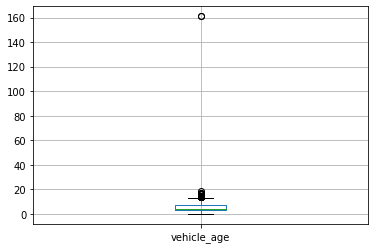

count    53799.000000
mean         4.850443
std          3.237982
min          0.000000
25%          3.000000
50%          4.000000
75%          7.000000
max        161.000000
Name: vehicle_age, dtype: float64

In [40]:
df.boxplot('vehicle_age')
plt.show()

df['vehicle_age'].describe()

There are emissions (more than 100 years old car). Let's limit the range of values from above to 20 years.

In [41]:
df = df.loc[df['vehicle_age'] <= 20]

***Party_sobriety***

In [42]:
df['party_sobriety'].value_counts(dropna=False)

had not been drinking                     46591
had been drinking, under influence         4298
impairment unknown                         1069
NaN                                         809
had been drinking, not under influence      552
had been drinking, impairment unknown       242
not applicable                              236
Name: party_sobriety, dtype: int64

There are gaps in the column. Let's fill them in with the category "not applicable".

In [43]:
df['party_sobriety'] = df['party_sobriety'].fillna('not applicable')

Now let's remove the common duplicate rows.

In [44]:
df.drop_duplicates(inplace=True)

**Results:**

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53372 entries, 0 to 54553
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   county_location              53372 non-null  object 
 1   distance                     53372 non-null  float64
 2   weather                      53372 non-null  object 
 3   party_count                  53372 non-null  int64  
 4   motor_vehicle_involved_with  53372 non-null  object 
 5   road_surface                 53372 non-null  object 
 6   road_condition               53372 non-null  object 
 7   lighting                     53372 non-null  object 
 8   control_device               53372 non-null  object 
 9   vehicle_type                 53372 non-null  object 
 10  vehicle_transmission         53372 non-null  object 
 11  vehicle_age                  53372 non-null  int64  
 12  at_fault                     53372 non-null  int64  
 13  party_sobriety  

**Final dataset** includes 15 traits (3 numeric, the rest categorical) and 1 target variable `at_fault`. There are a total of 53372 rows. All omissions and outliers have been eliminated.

Sample splitting:

In [46]:
features = df.drop(columns='at_fault')
target = df['at_fault']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=123)

Scaling of numerical features and coding of categorical features are further used as part of the Pipeline.

## Model creation

The task of accident prediction is reduced to a classification task. To evaluate the quality of the models, we choose the **f1-score** metric, since the balance between completeness and accuracy of offender prediction is important. 

Let us compare **three ML algorithms** of different types to train the models:
1. **Logistic regression*.
2. *Random Forest*.
3. *Gradient boosting*.

As we know, OHE as categorical feature encoding, works well for linear models, but for all others, often not the right choice. Therefore, we will use OHE for linear regression, and OrdinalEncoding for random forest and bousting.

In [47]:
# table for storing results
results = pd.DataFrame(columns=['model', 'f1_score', 'mean_fit_time'])

In [48]:
# numeric features
numeric = ['distance', 'party_count', 'vehicle_age']

# categorical features
categorical = ['county_location', 'weather', 'motor_vehicle_involved_with', 
               'road_surface', 'road_condition', 'lighting', 'control_device', 
               'vehicle_type', 'vehicle_transmission', 'party_sobriety', 
               'month', 'day_of_week', 'part_day']

# preprocessor for linear models
preprocessor_linear = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric),
        ('cat', OneHotEncoder(), categorical)])

# preprocessor for unlinear models
preprocessor_non_linear = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric),
        ('cat', OrdinalEncoder(), categorical)])

In [ ]:
%%time
# Logistic regression
params = {'lr__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

pipe = Pipeline(steps=[
    ('preprocessor',  preprocessor_linear),   
    ('lr', LogisticRegression(random_state=123, class_weight='balanced', max_iter=1000))])  # классификатор

grid = GridSearchCV(pipe, param_grid=params, scoring='f1', cv=5, n_jobs=4)
grid.fit(features_train, target_train)

print("Лучшие параметры: {}".format(grid.best_params_))
print("Лучший результат (f1): {:.2f}".format(grid.best_score_))
print()

results.loc[len(results.index)] = ['Logistic regression', grid.best_score_, pd.DataFrame(grid.cv_results_).query('rank_test_score == 1')['mean_fit_time'].values[0]]

In [ ]:
%%time
# Random forest
params = {'rf__n_estimators': [50, 100, 250, 500],
          'rf__max_depth': range(5, 10)}

pipe = Pipeline(steps=[
    ('preprocessor',  preprocessor_non_linear),  
    ('rf', RandomForestClassifier())])         

grid = GridSearchCV(pipe, param_grid=params, scoring='f1', cv=3, n_jobs=4)
grid.fit(features_train, target_train)

print("Лучшие параметры: {}".format(grid.best_params_))
print("Лучший результат (f1): {:.2f}".format(grid.best_score_))
print()

results.loc[len(results.index)] = ['Random forest', grid.best_score_, pd.DataFrame(grid.cv_results_).query('rank_test_score == 1')['mean_fit_time'].values[0]]

In [ ]:
%%time
# Gradient boosting
params = {'lgbm__n_estimators': [50, 100, 250, 500],
          'lgbm__max_depth': range(5, 10), 
          'lgbm__learning_rate': [0.5, 1]}

pipe = Pipeline(steps=[
    ('preprocessor',  preprocessor_non_linear),      
    ('lgbm', LGBMClassifier())])                     

grid = GridSearchCV(pipe, param_grid=params, scoring='f1', cv=3, n_jobs=4)
grid.fit(features_train, target_train)

print("Лучшие параметры: {}".format(grid.best_params_))
print("Лучший результат (f1): {:.2f}".format(grid.best_score_))
print()

results.loc[len(results.index)] = ['LGBM', grid.best_score_, pd.DataFrame(grid.cv_results_).query('rank_test_score == 1')['mean_fit_time'].values[0]]

Results:

In [ ]:
results

The gradient boosting model performed best in both training time (approximately 1 sec) and quality: **f1-score** 0.6436. 

**Final model testing**:

In [ ]:
# model fitting
pipe = Pipeline(steps=[
    ('preprocessor',  preprocessor_non_linear),
    ('lgbm', LGBMClassifier(learning_rate=0.5, max_depth=5, n_estimators=50))])                     # классификатор

pipe.fit(features_train, target_train)
print()

In [ ]:
# predictions
preds = pipe.predict(features_test)
f1 = f1_score(target_test, preds)
print('F1-score на тестовой выборке:', round(f1, 4))

# confusion matrix
cm = confusion_matrix(target_test, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Предсказанные значения')
plt.ylabel('Фактические значения')
plt.title('Матрица ошибок')

# precision and recall
precision = precision_score(target_test, preds)
recall = recall_score(target_test, preds)

print('Точность:', round(precision, 4))
print('Полнота:', round(recall, 4))

Thus, the gradient boosting model performed about the same on the test sample as on the training sample. Accuracy was higher than completeness. Consequently, the model accurately enough separates one class from another (identifies the culprit of the accident), however, it does not identify all representatives of the class.

## Analyzing the importance of road traffic accident factors

In [ ]:
feature_importance = pipe.named_steps['lgbm'].feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features_train.columns, 'Importance': feature_importance})

# sorting
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Важность признаков')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

The most important factor was location (`county_location`). Next were weather (`weather`) and number of participants (`party_count`). 

For an example, the influence of weather conditions on class distribution:

In [ ]:
(pd.crosstab(df['weather'], df['at_fault'], normalize='index')
 .sort_values(by=1, ascending=False)
 .plot(kind='bar'))
 
plt.xticks(rotation=45)
plt.title('Распределение классов в зависимости от погодных условий')
plt.ylabel('class_rate')
plt.show()

The highest number of accidents is recorded under unfavorable weather conditions: snow, fog and rain. When the weather is clear, however, the distribution of classes is even. To take this factor into account, it is possible to equip the car with electronics with installed programs that show the weather forecast in the region during the entire route and warn in advance of possible changes.

## Conclusion

As part of this project:
1. Data upload from the provided database was generated according to the task. 
2. exploratory analysis of the data was performed: some features were transformed, omissions and outliers were eliminated in the remaining columns. Before training, categorical features were coded and numerical features were scaled.
3- Optimized hyperparameter models trained with three different ML algorithms were compared: *logistic regression*, *random forest*, and *gradient boosting*. The selected quality assessment metric was *F1-score*.
4. The **LGBM model** with the following hyperparameter values max_depth=5, n_estimators=50, learning_rate=0.5 showed the best result. The obtained F1-score on the training sample is: **0.6436**. F1-score on the test sample: **0.6464**.
5. Additionally, the importance of features for the model was analyzed. Thus, the most significant were location (region), weather and number of participants.

Thus, it is possible to create an adequate system of risk assessment for car loans, but so far the quality of the model prediction is not very high. The improvement of the result is likely to be influenced by the addition of new attributes, for example, driving experience.